In [15]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '1'
import torch
from diffusers import FluxFillPipeline
from detector.groundingdino_sam import GroundingdinoSam
from PIL import Image
import cv2
import numpy as np

In [2]:
flux_fill = '/amax/hchuz/hfd_models/FLUX.1-Fill-dev'
dino_checkpoint = '/amax/hchuz/OMG-master/checkpoint/GroundingDINO'
sam_checkpoint = '/amax/hchuz/OMG-master/checkpoint/sam/sam_vit_h_4b8939.pth'

In [3]:
groundingdino_sam = GroundingdinoSam(dino_checkpoint, sam_checkpoint)
pipe = FluxFillPipeline.from_pretrained(flux_fill, torch_dtype=torch.bfloat16)
_ =pipe.to("cuda")

final text_encoder_type: bert-base-uncased


Model loaded from groundingdino_swinb_cogcoor.pth 
 => _IncompatibleKeys(missing_keys=[], unexpected_keys=['label_enc.weight', 'bert.embeddings.position_ids'])


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

You set `add_prefix_space`. The tokenizer needs to be converted from the slow tokenizers


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

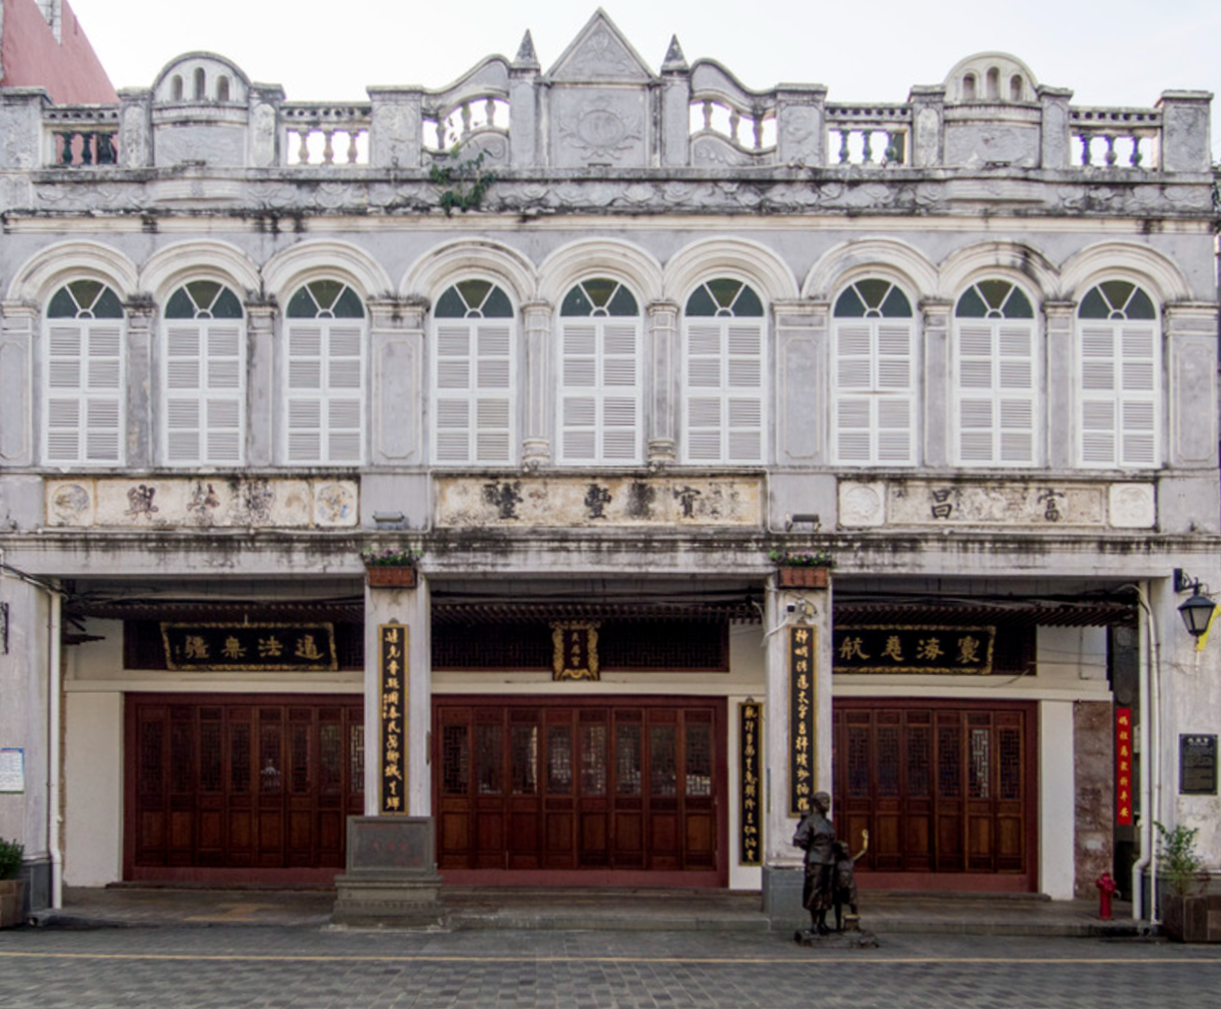

In [4]:
global_style_image = Image.open('/amax/hchuz/architectural_heritage/temp/Snipaste_2023-02-21_13-33-06.png').convert('RGB')
global_style_image

In [17]:
box = groundingdino_sam.pred_box_with_prompt(global_style_image, 'human')[0]
box

[792.7045288085938, 790.3768310546875, 854.4403076171875, 934.9390258789062]

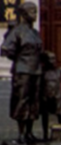

In [18]:
global_style_image.crop(box)

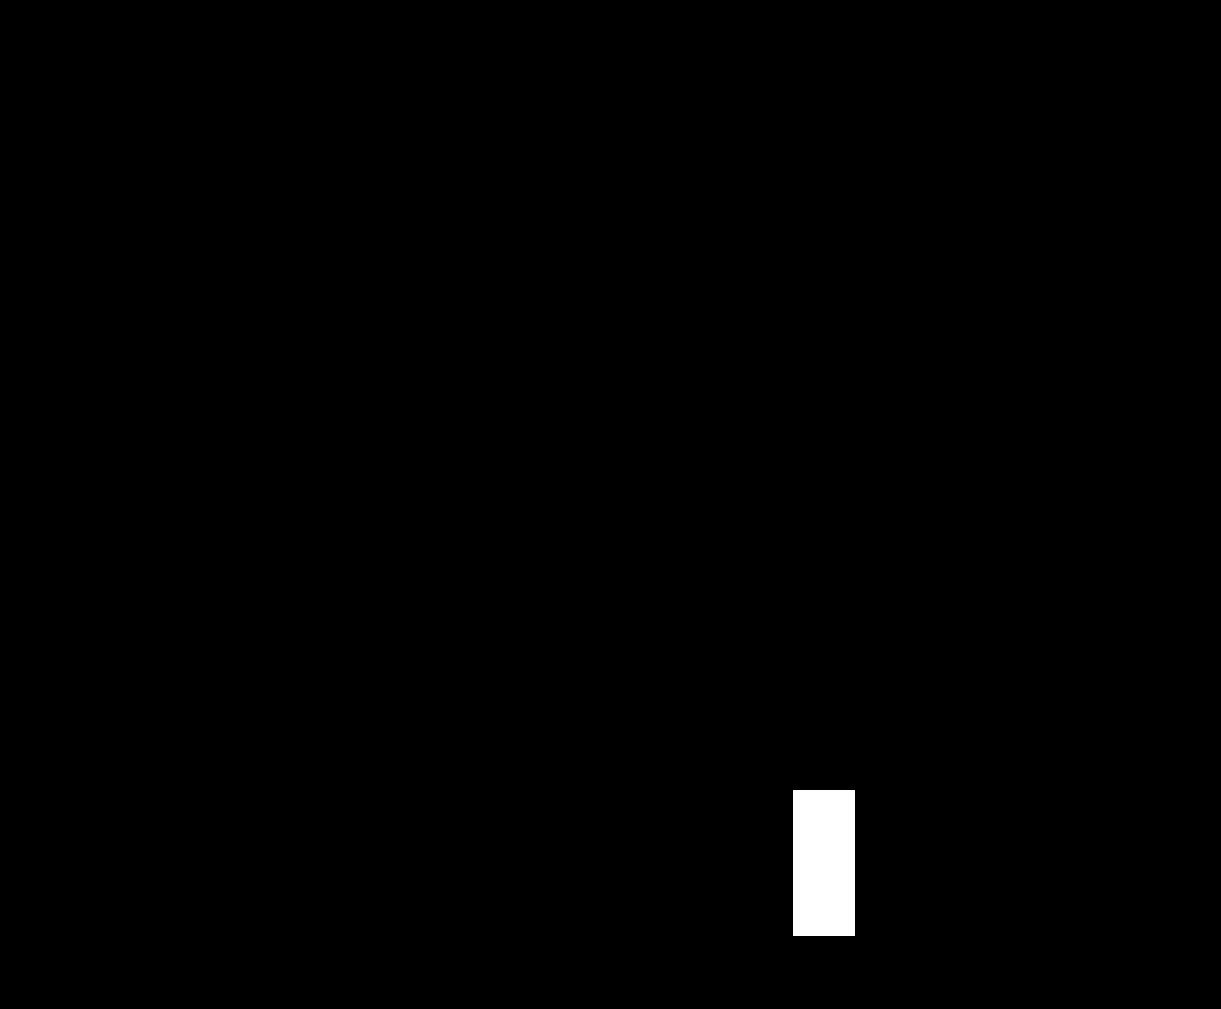

In [28]:
x_min, y_min, x_max, y_max = map(int, map(round, box))

# 创建一个空白图像（假设图像大小足够大，或根据需要动态调整大小）
image_height = global_style_image.height
image_width = global_style_image.width
mask = np.zeros((image_height, image_width), dtype=np.uint8)

# 在掩码上绘制矩形
cv2.rectangle(mask, (x_min, y_min), (x_max, y_max), color=255, thickness=-1)
Image.fromarray(mask)

`height` and `width` have to be divisible by 16 but are 1009 and 1221. Dimensions will be resized accordingly


  0%|          | 0/20 [00:00<?, ?it/s]

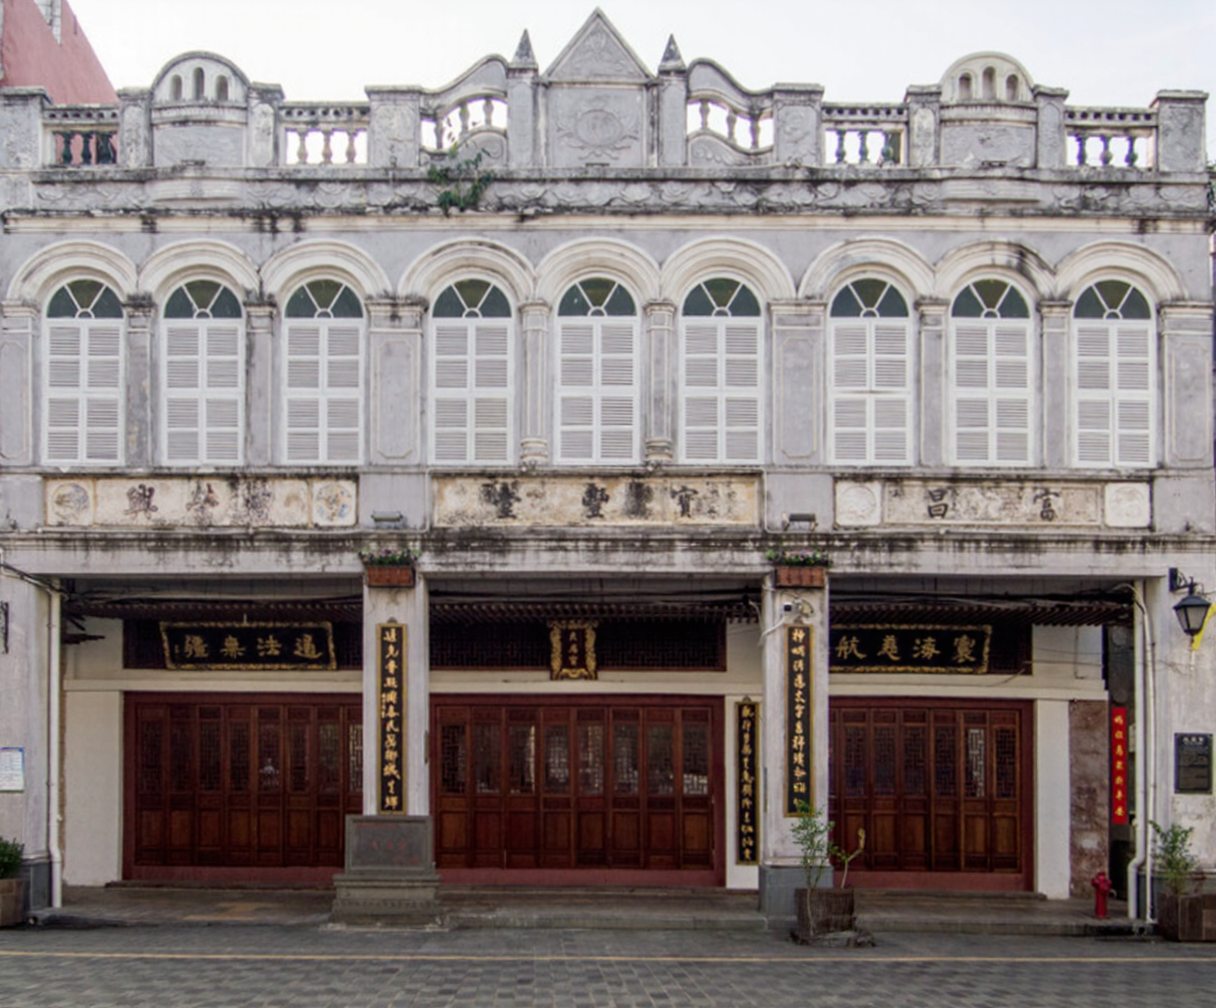

In [30]:
image = pipe(
    prompt='',
    image=global_style_image,
    mask_image=torch.from_numpy(mask).float(),
    height=global_style_image.height,
    width=global_style_image.width,
    num_inference_steps=20,
    generator=torch.Generator("cpu").manual_seed(42),
).images[0]
image

In [31]:
image.save('temp/Snipaste_2023-02-21_13-33-06_no_human.png')